In [24]:
cd C:\Users\LIMDAESUN\for_github\Fixed_Income_and_Interest_Derivatives

C:\Users\LIMDAESUN\for_github\Fixed_Income_and_Interest_Derivatives


 # 목차
 ### 1. Discount Function
 ### 2. Swap Rate and Old Swap Value
 ### 3. Forward Swap Rate and Swaption
### 4. Caplet , Floorlet Pricing
 ### 5. Merton Credit Model
  ### 6. Risky Bond Pricing or Riskless Bond Pricing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
from scipy.optimize import root

In [3]:
Initial_Data = pd.read_excel('Discount_Mar_26.xlsx', parse_dates=['Maturity Date']).set_index('Maturity Date')
Discount = Initial_Data.Discount

In [4]:
pricing_date = pd.datetime(2020,3,26)

 ### 1. Discount Function

In [5]:
def interpolated_DF(pricing_date, Discount, freq_month = 3) :
    ################################################################################
    ### 0 to 1 day interest rate은 가장 짧은 Curve Interest Rate과 같다고 가정    ##
    ### Assuming that 1 day interest rate is equal to first interest of the curve ##
    ################################################################################    
    r0 = (1/Discount.iloc[0] -1) * 360/(Discount.index[0].to_pydatetime() - pricing_date).days
    DF0 = 1/(1+r0 * 1/360)
    Discount0= pd.Series([DF0], index = [pricing_date + datetime.timedelta(days = 1)], name = 'Discount')

    ################################
    ### Log Linear Interpolation ###
    ################################
    discount = np.exp(np.log(pd.concat([Discount0, Discount], axis = 0).resample('D').last()).interpolate(method = 'linear'))
    end_date = pd.datetime(discount.index[-1].year,discount.index[-1].month, 1) 
    date_index = pd.Series(pd.date_range(pd.datetime(pricing_date.year,pricing_date.month, 1),                                                            
                                         end_date, freq = 'MS')[freq_month::freq_month]) + datetime.timedelta(days = pricing_date.day-1)
    return discount.loc[date_index]

def Forward_Rate_Curve(pricing_date, Discount, freq_month = 3) :
    DF =  interpolated_DF(pricing_date, Discount, freq_month)
    ## r0 is F(0,t1)
    r0 = ( 1/DF.iloc[0] - 1)  * 360/(DF.index[0].to_pydatetime() - pricing_date).days
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    F_1_to_M = (np.array(DF.iloc[:-1]) / np.array(DF.iloc[1:]) - 1) * 360/np.array(dt.iloc[1:])
    return pd.Series(np.concatenate([[r0], F_1_to_M]), index = DF.index)

def Continuous_Zero_Rate(pricing_date, Discount, freq_month = 3):
    DF = interpolated_DF(pricing_date, Discount, freq_month)
    my_lamb = lambda x : 365 if  x >= 365 else 360
    Time = (pd.Series(DF.index) - pricing_date).apply(lambda x: x.days).apply(my_lamb)
    T = (pd.Series(DF.index) - pricing_date).apply(lambda x: x.days)/Time
    T.index = DF.index    
    continuous_zero = -np.log(DF) * 1/T
    return continuous_zero
def F_Rate(pricing_date, Discount, t0, tenor ,freq_month = 3):
    ################################
    ### Calculate Forward Rate  ####
    ### t0 = Forward Maturity   ####
    ################################
    DF =  interpolated_DF(pricing_date, Discount, freq_month)
    T0 = int(t0*(12/freq_month))
    T1 = T0 + int(tenor*(12/freq_month)) # Swap Maturity Date
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    P0 = np.concatenate([[1],np.array(DF)])[T0]
    P1 = np.concatenate([[1],np.array(DF)])[T1]
    DeltaT = (dt.iloc[T0:T1]).sum()/365
    F = 1/DeltaT * (P0/P1-1)
    return F

### 2. Swap Rate and Old Swap Value
#### Swap Rate
\begin{align}
 \ S = \frac{a}{b} \\ a = \sum_{i=1}^{m}[P(0,t_{i-1}) e^{\lambda \Delta t_i} - P(0,t_{i})],\ ( \lambda = hazard \ rate) \\ b = \sum_{i=1}^{m} \Delta t_i P(0,t_i) \
 \end{align}
#### Old Swap Value
\begin{align}
 \\\\ V_{swap} = (s^\star - s ) \sum_{i=1}^{m} \Delta t_i P(0,t_i) \\
 \end{align}

In [6]:
def Swap_Rate(pricing_date, Discount, t, freq_month_of_Discount = 3, hazard_rate = 0) :
    lamb = hazard_rate
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    T = int(t*(12/freq_month_of_Discount))
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    P = np.concatenate([[1],np.array(DF.iloc[:T])])
    Deltat = np.array(dt.iloc[:T])/365
    a = (P[:-1] * np.exp(lamb * Deltat) - P[1:]).sum()
    b = ( np.array(dt.iloc[:T]/365) * np.array(DF)[:T]).sum()
    s = a/b
    return s

def Old_Swap_Value(S_old, pricing_date, t, freq_month_of_Discount = 3, hazard_rate = 0) :
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    S_new = Swap_Rate(pricing_date, Discount, t, freq_month_of_Discount, hazard_rate)     
    T = int(t*(12/freq_month_of_Discount))
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    P = np.array(DF.iloc[:T])
    Deltat = np.array(dt.iloc[:T])/365
    value = (S_new - S_old) * (P * Deltat).sum()
    return value

 #### Curve Calculation Example

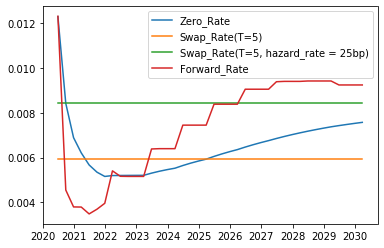

In [23]:
CZR = Continuous_Zero_Rate(pricing_date, Discount).iloc[:40]
FRC = Forward_Rate_Curve(pricing_date, Discount, freq_month = 3).iloc[:40]
S_5 = Swap_Rate(pricing_date, Discount, t=5)
S_5_hazard = Swap_Rate(pricing_date, Discount, t=5 ,hazard_rate = 0.0025)
plt.figure()
plt.plot(CZR, label = 'Zero_Rate')
plt.plot(pd.Series([S_5]*len(CZR.index), index = CZR.index), label = 'Swap_Rate(T=5)')
plt.plot(pd.Series([S_5_hazard]*len(CZR.index), index = CZR.index), label = 'Swap_Rate(T=5, hazard_rate = 25bp)')
plt.plot(FRC, label = 'Forward_Rate')
plt.legend(loc = 'best')
plt.show()

 #### Old Swap Value

In [8]:
Old_Swap_Value(0.005, pricing_date, t=5, freq_month_of_Discount = 3, hazard_rate = 0)

0.004560743846249403

### 3. Forward Swap Rate and Swaption
#### Forward Swap Rate
\begin{align}
 \ FSR_0(T_0, tenor = \Delta T) = \frac{ P(0,T_0) - P(0,T_0 + \Delta T)}{\sum_{i=1}^{T_0 + \Delta T} \Delta t_i P(0,T_i)} \
 \end{align}
 
 #### Swaption
 \begin{align}
 \ V_0 = [FSR_0(T_0,  \Delta T) N(d_1) - X N(d_2)] \sum_{i=1}^{T_0 + \Delta T} \Delta T_i P(0, T_i) \
 \end{align}

In [9]:
def Forward_Swap_Rate(pricing_date, Discount, t0, tenor, freq_month_of_Discount = 3, hazard_rate = 0, Fixed_lag = False) :
    t = t0 # t0 is Forward Maturity
    lamb = hazard_rate
    
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    T0 = int(t*(12/freq_month_of_Discount))
    T1 = T0 + int(tenor*(12/freq_month_of_Discount)) # Swap Maturity Date
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    DF_0_to_m = np.concatenate([[1],DF])[T0:T1+1]
    Deltat = np.array(dt.iloc[T0:T1])/365
    a = (DF_0_to_m[:-1] * np.exp(lamb * Deltat) - DF_0_to_m[1:]).sum()
    b = (Deltat * np.array(DF)[T0:T1]).sum()
    s = a/b
    if Fixed_lag == False :
        return s 
    else :
        return s, b
def Swaption(pricing_date, Discount, t0 , tenor, X, sigma, freq_month_of_Discount = 3, hazard_rate = 0) :
    FSR, b = Forward_Swap_Rate(pricing_date, Discount, t0, tenor, freq_month_of_Discount, hazard_rate, Fixed_lag = True)
    if t0 == 0 :
        return max(FSR - X, 0) * b
    else :
        d1 = ( np.log(FSR/X) + 0.5 * sigma**2 * t0 )/ (sigma * np.sqrt(t0))
        d2 = d1 - sigma * np.sqrt(t0)
        Nd1 = norm.cdf(d1)
        Nd2 = norm.cdf(d2)
        V = FSR * Nd1 - X * Nd2
        return V * b

In [10]:
Swap_Rate(pricing_date, Discount, t = 2, freq_month_of_Discount = 3, hazard_rate = 0)

0.00519942477943924

In [11]:
Forward_Swap_Rate(pricing_date, Discount, t0= 0, tenor= 2, freq_month_of_Discount = 3, hazard_rate = 0)

0.00519942477943924

In [12]:
Forward_Swap_Rate(pricing_date, Discount, t0= 1, tenor= 3, freq_month_of_Discount = 3, hazard_rate = 0)

0.005291966106261326

In [13]:
Swaption(pricing_date, Discount, t0= 1, tenor= 3,X = 0.005, sigma = 0.01, freq_month_of_Discount = 3, hazard_rate = 0)

0.0008645330402783434

### 4. Caplet , Floorlet Pricing
#### Caplet, Floorlet
 \begin{align}
 \ c(0) = \Delta T \times P(0,T+\Delta T) [ f_0(T,T+\Delta T) N(d_1) - X N (d_2)]\
 \\
 \\
 \ p(0) = \Delta T \times P(0,T+\Delta T) [ X N (-d_2) - f_0(T,T+\Delta T) N(-d_1)]\
 \\ \\ \ d_1 = \frac{ln( \frac{f_0(T,T+\Delta T)}{X} ) + \frac{1}{2} \sigma^2 T}{\sigma \sqrt{T}} , \ d_2 = d_1 - \sigma \sqrt{T} \
 \end{align}

In [14]:
def Caplet_Pricing(pricing_date, Discount, t0, tenor, X, sigma, freq_month_of_Discount = 3) :
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    T0 = int(t0*(12/freq_month_of_Discount))
    T1 = T0 + int(tenor*(12/freq_month_of_Discount)) # Swap Maturity Date
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    P0 = np.concatenate([[1],np.array(DF)])[T0]
    P1 = np.concatenate([[1],np.array(DF)])[T1]
    DeltaT = (dt.iloc[T0:T1]).sum()/365
    F = 1/DeltaT * (P0/P1-1)
    d1 = ( np.log(F/X) + 0.5 * sigma**2 * t0 ) / (sigma * np.sqrt(t0) )
    d2 = d1 - sigma * np.sqrt(t0)
    C = DeltaT * DF.iloc[T1-1] * (F * norm.cdf(d1) - X *  norm.cdf(d2))    
    return C

def Floorlet_Pricing(pricing_date, Discount, t0, tenor, X, sigma, freq_month_of_Discount = 3) :
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    T0 = int(t0*(12/freq_month_of_Discount))
    T1 = T0 + int(tenor*(12/freq_month_of_Discount)) # Swap Maturity Date
    dt = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)
    P0 = np.concatenate([[1],np.array(DF)])[T0]
    P1 = np.concatenate([[1],np.array(DF)])[T1]
    DeltaT = (dt.iloc[T0:T1]).sum()/365
    F = 1/DeltaT * (P0/P1-1)
    d1 = ( np.log(F/X) + 0.5 * sigma**2 * t0 ) / (sigma * np.sqrt(t0) )
    d2 = d1 - sigma * np.sqrt(t0)
    P = DeltaT * DF.iloc[T1-1] * ( X * norm.cdf(-d2) - F * norm.cdf(-d1))    
    return P

In [15]:
Caplet_Pricing(pricing_date, Discount, t0 = 1, tenor = 0.5, X = 0.003, sigma = 0.01, freq_month_of_Discount = 3)

0.00031588918306713125

In [16]:
F_Rate(pricing_date, Discount, t0 = 1, tenor = 0.5)

0.00363168386151837

In [17]:
Floorlet_Pricing(pricing_date, Discount, t0 = 1, tenor = 0.5, X = 0.004, sigma = 0.01, freq_month_of_Discount = 3)

0.00018418562066116538

 ### 5. Merton Credit Model
 \begin{align}
 \ E = A_{MKT} N(d_1) - F e^{-rT} N(d_2) .... ⓐ\\ \\
 \ \sigma_E = \frac{A_{MKT}}{E} N(d_1) \sigma_A.... ⓑ \\
 \\
 \ Using \ Simultanous \ Equation \\
 \ Find \ Market \ Value \ of \ Asset \ and \ Volatility\ of \ Asset \ ( \ 
 A_{MKT} ,\ \sigma_E \ ) \\ \\ PD = 1 - N( d_2 ) \
 \end{align}

In [18]:
def Optimize_Merton(F,r,T,sigma_E,E_market_value) :
    E_market = E_market_value
    def EandsigmaE(x,F) :
        sig_A = x[0]
        A = x[1]
        d1 = (np.log(A/F) + (r + 0.5 * sig_A**2)*T)/(sig_A * np.sqrt(T))
        d2 = d1 - sig_A * np.sqrt(T)
        Nd1 = norm.cdf(d1)
        Nd2 = norm.cdf(d2)
        E = A * Nd1 - F * np.exp(-r * T) * Nd2
        sig_E = A/E * Nd1 * sig_A
        return np.array([sig_E,E])
    def fun(x,F,ans) :
        return EandsigmaE(x,F) - ans

    x0 = np.array([0.3, 10000])
    ret = root(fun, x0, args = (F, np.array([sigma_E,E_market]) ) )
    sigA, MV_Asset = ret.x[0], ret.x[1] ## Return sigA and Market Value of Asset
    return np.round(sigA,4) , np.round(MV_Asset,4)

def Merton_Debt_Value(F,r,T,sigma_E, E_market_value) :
    sig_A , A = Optimize_Merton(F, r, T, sigma_E, E_market_value)
    d1 = (np.log(A/F) + (r + 0.5 * sig_A**2)*T)/(sig_A * np.sqrt(T))
    d2 = d1 - sig_A * np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    E = A * Nd1 - F * np.exp(-r * T) * Nd2 
    D = A-E
    return D

def Merton_Default_Prob(F,r,T,sigma_E, E_market_value) :
    sig_A , A = Optimize_Merton(F, r, T, sigma_E, E_market_value)
    d1 = (np.log(A/F) + (r + 0.5 * sig_A**2)*T)/(sig_A * np.sqrt(T))
    d2 = d1 - sig_A * np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    PD = 1 - Nd2
    Annualized_PD = - 1/T * np.log(1-PD)
    return Annualized_PD

In [19]:
Merton_Default_Prob(F = 3000, r = 0.006, T = 5, sigma_E = 0.3, E_market_value = 5000)

0.003362667508384866

 ### 6. Risky Bond Pricing or Riskless Bond Pricing
#### Zero Coupon Bond
\begin{align}
 \ Z(0,T) = e^{-(r+\lambda)T} + RR \bullet \int_{0}^{T} Z(0,t) d(-Q(0,t)) 
 \\ =P(0,T) Q(0,T) + RR \bullet \sum_{i = 1}^{m} Z(0,t_i)[Q(0,t_{i-1}) - Q(0,t_{i})] \
 \end{align}
#### Coupon Bond
\begin{align}
\ CB = \sum_{i=1}^{m}CF(t_i) \bullet Z(0,t_i) \
\end{align}

In [20]:
def Zero_Bond(pricing_date, Discount,t, freq_month_of_Discount = 3,hazard_rate=0, Recovery = 0) :
    RR = Recovery
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    surv = np.exp(-hazard_rate * t)
    T = int(12/freq_month_of_Discount * t)-1
    P = DF.iloc[T]
    value_at_nondefault = P * surv
    
    DeltaT = pd.Series(DF.index).diff().apply(lambda x : x.days).fillna((DF.index[0] - pricing_date).days)/365
    Q = np.exp(-hazard_rate * DeltaT).cumprod()
    Q.index = DF.index
    dQ_ = np.concatenate([[1],np.array(Q)])[:-1] - np.concatenate([[1],np.array(Q)])[1:]
    value_at_default = RR * (np.array(DF)[:T+1] * dQ_[:T+1]).sum()
    return value_at_nondefault + value_at_default

def Coupon_Bond(pricing_date, Discount,t, C_rate , 
                freq_month_of_Discount = 3,freq_month_of_Coupon = 6,
                hazard_rate=0, Recovery = 0) :
    dt =  freq_month_of_Coupon/12
    Trange = np.arange(dt, t+dt, dt)
    DF = interpolated_DF(pricing_date, Discount, freq_month_of_Discount)
    n = int(freq_month_of_Coupon/freq_month_of_Discount)
    Delta_T = np.array((pd.Series(DF.index[n-1::n]).diff().apply(lambda x : x.days).fillna((DF.index[n-1]- pricing_date).days)/365).iloc[:int(t * 12/freq_month_of_Coupon)])
    price = 0
    for ii, i in enumerate(Trange) :
        price +=C_rate * Delta_T[ii] *Zero_Bond(pricing_date, Discount,i, freq_month_of_Discount,hazard_rate, Recovery)
    price += Zero_Bond(pricing_date, Discount,Trange[-1], 
                       freq_month_of_Discount,hazard_rate, Recovery)
    return price

 #### If Coupon Rate == Swap Rate :
 #### 　Coupon Bond Price = 1

In [21]:
C_rate = Swap_Rate(pricing_date, Discount, 3, freq_month_of_Discount = 3, hazard_rate = 0)
CB = Coupon_Bond(pricing_date, Discount,t=3, C_rate=C_rate ,                  
                 freq_month_of_Discount = 3,freq_month_of_Coupon = 3,
                 hazard_rate=0, Recovery = 0)
CB

1.0

In [22]:
CB_risky = Coupon_Bond(pricing_date, Discount, t = 3, C_rate = 0.006,
                      hazard_rate = 0.01, Recovery = 0.5) 
CB_risky

0.9877387885844174